# Comparing FBA and Tnseq results

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cobra, re

# Functions

In [3]:
def float_convert(x):
    try:
        y = float(x)
    except:
        y = None
    return y

# Load

In [4]:
"""Tn-Seq"""
# Skip these cols
skip_cols = ['orgId', 'locusId', 'sysName', 'desc']
tnseq = pd.read_csv('ecoli_tnseq.tsv', '\t', index_col='geneName')
tnseq = tnseq[[c for c in tnseq if c not in skip_cols]]

# TnSeq t-scores
tscores = pd.read_csv('t_organism_Keio.tsv', '\t', index_col='geneName')
tscores = tscores[[c for c in tnseq if c not in skip_cols]]

# Metadata
md = pd.read_csv('ecoli_md.tsv', '\t')
md['Sample'] = md[['expName', 'expDesc']].apply(lambda x: ' '.join(x), 1)
md['concentration_1'] = md.concentration_1.apply(float_convert)
# md['condition'] = md[['aerobic', 'condition_1', 'condition_2']].astype(str).apply(lambda x: '_'.join(x), 1)

"""FBA results"""
# Model, for getting metabolite names
model = cobra.io.read_sbml_model('ecoli_model.xml')

fba = pd.read_csv('fba_results/ecoli_fba_m9.csv', index_col=0)

md.head()

,orgId,expName,expDesc,timeZeroSet,num,nMapped,nPastEnd,nGenic,nUsed,gMed,...,concentration_2,condition_3,units_3,concentration_3,condition_4,units_4,concentration_4,growthPlate,growthWells,Sample
0,Keio,set10IT002,"LB, Aerobic",7/20/2015 Keio_ML9_set10,555,954600,0,658766,658236,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"set10IT002 LB, Aerobic"
1,Keio,set10IT004,LB Aerobic with Phenazine ethosulfate 0.000062...,7/20/2015 Keio_ML9_set10,557,901412,0,630562,630227,59,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT004 LB Aerobic with Phenazine ethosulfa...
2,Keio,set10IT005,LB Aerobic with Spiramycin 0.000125 mM,7/20/2015 Keio_ML9_set10,558,1012731,0,705994,705460,120,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT005 LB Aerobic with Spiramycin 0.000125 mM
3,Keio,set10IT006,LB Aerobic with Spiramycin 0.0000625 mM,7/20/2015 Keio_ML9_set10,559,1051529,0,729527,728846,130,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT006 LB Aerobic with Spiramycin 0.000062...
4,Keio,set10IT007,LB Aerobic with Oxytetracycline 0.00000125 mM,7/20/2015 Keio_ML9_set10,560,984917,0,733951,732897,96,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set10IT007 LB Aerobic with Oxytetracycline 0.0...


# Shared media names between FBA and TnSeq
And create shared condition nomenclature

## M9

In [5]:
"""M9 fba"""
m9_md = md[md.media.isin(['M9 minimal media_noCarbon', 'M9 minimal media_noNitrogen'])].reset_index(drop=True)
m9_md['condition'] = m9_md[['media', 'condition_1']].apply(lambda x: f'm9_no_{"c" if "Carbon" in x.media else "n"}+' + x.condition_1.lower(), 1)
m9_md.head()

,orgId,expName,expDesc,timeZeroSet,num,nMapped,nPastEnd,nGenic,nUsed,gMed,...,condition_3,units_3,concentration_3,condition_4,units_4,concentration_4,growthPlate,growthWells,Sample,condition
0,Keio,set1IT003,D-Glucose (C),6/19/2014 Keio_ML9_set1,3,1831987,0,1245629,1244431,206,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set1IT003 D-Glucose (C),m9_no_c+d-glucose
1,Keio,set1IT004,D-Glucose (C),6/19/2014 Keio_ML9_set1,4,1718470,0,1168204,1167102,195,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set1IT004 D-Glucose (C),m9_no_c+d-glucose
2,Keio,set1IT005,D-Fructose (C),6/19/2014 Keio_ML9_set1,5,1999827,0,1359778,1358459,222,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set1IT005 D-Fructose (C),m9_no_c+d-fructose
3,Keio,set1IT006,D-Fructose (C),6/19/2014 Keio_ML9_set1,6,2139479,0,1454760,1453365,241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set1IT006 D-Fructose (C),m9_no_c+d-fructose
4,Keio,set1IT007,Sucrose (C),6/19/2014 Keio_ML9_set1,7,1916286,0,1303666,1302442,214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,set1IT007 Sucrose (C),m9_no_c+sucrose


## LB 

In [4]:
"""Base LB media conditions"""
lb_md_idxs = md.media.eq('LB') & md.condition_1.isnull() & md.condition_2.isnull()

"""Supplemental conditions that FBA was performed in"""
# Get names of supplemental exchange reactions from FBA results
exchange_rxns = list(set([re.findall('_(EX_\w*)', c)[0] for c in fba if re.findall('_(EX_\w*)', c)]))
# Get name of supplemental media
supps_mapping = {r: model.exchanges.get_by_id(r).name.split(' exchange')[0].lower() for r in exchange_rxns}

supp_md_idxs = md.media.eq('LB') & md.condition_1.astype(str).str.lower().isin(supps_mapping.values()) | (md.condition_2.astype(str).str.lower().isin(supps_mapping.values()) & md.condition_1.isnull())

"""Combine"""
conditions_md = md[lb_md_idxs | supp_md_idxs].reset_index(drop=True)
# Add column to indicate condition name
conditions_md['condition'] = conditions_md[['condition_1', 'condition_2', 'aerobic']].fillna('').apply(lambda x: re.sub('\s+', '_', ' '.join(x).strip().lower()), 1)

"""Rename FBA conditions"""
def renameFBA(x):
    if x.endswith('_lb'):
        new = x.split('_lb')[0]
    else:
        o2 = x.split('_')[0]
        cond = supps_mapping[re.findall('\w+(EX_\w+)', x)[0]]
        new = f'{cond}_{o2}'.replace(' ', '_')
    return new
fba = fba.rename(columns=renameFBA)
fba.head()

,aerobic,chloramphenicol_aerobic,l-lysine_aerobic,dimethyl_sulfoxide_aerobic,anaerobic,chloramphenicol_anaerobic,l-lysine_anaerobic,dimethyl_sulfoxide_anaerobic
grxB,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
waaY,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
mrdA,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
ompF,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444
gabD,41.999324,41.999324,41.999324,44.68373,33.051058,33.051058,33.051058,35.735444


# Compare FBA simulations with Tn-seq

In [34]:
"""Combine FBA and Tn-seq data"""
# Melt subsetted tnseq data
tnseq_sub = tnseq[m9_md.Sample].rename_axis(index='gene', columns='Sample').stack().reset_index(name='fitness')
# Melt tscores
tscores_sub = tscores[m9_md.Sample].rename_axis(index='gene', columns='Sample').stack().reset_index(name='tscore')
# Add metadata and take mean fitness for each condition
### LB
# tnseq_mean_fit = tnseq_sub.merge(tscores_sub).merge(conditions_md[['Sample', 'condition']]).groupby(['gene', 'condition'])[['fitness', 'tscore']].mean()
#### M9
tnseq_mean_fit = tnseq_sub.merge(tscores_sub).merge(m9_md[['Sample', 'condition']]).groupby(['gene', 'condition'])[['fitness', 'tscore']].mean()
# Normalize FBA
fba_norm = fba / fba.loc['wildtype']
# fba_norm = fba.loc[fba.index!='wildtype'] / fba.loc[fba.index!='wildtype'].mean()
fba_melted = fba_norm.loc[fba_norm.index.difference(['wildtype'])].rename_axis(index='gene', columns='condition').stack().rename('fba')

# Combine
def getMedia(x):
    if (x=='aerobic') | (x=='anaerobic'):
        return 'LB'
    else:
        return 'LB+'+x.split('_aerobic')[0].split('_anaerobic')[0]
    
# Merge FBA and TnSeq data, including all FBA genes (absent from TnSeq = TRULY essential)
combo = pd.merge(fba_melted.reset_index(), tnseq_mean_fit.reset_index(), 'left')
combo['tnseq_essential'] = combo.fitness.isnull()
na_fill = combo.fitness.min() * 1.2
combo['fitness'] = combo.fitness.fillna(na_fill)
# combo['media'] = combo.condition.apply(getMedia)
combo['col_name'] = combo.condition.str.replace('+', '+\n')
combo['anaerobic'] = combo.condition.str.contains('anaerobic')
# Filter out |t| < 4
filtered = combo[(combo.tscore.abs() > 4) | combo.tnseq_essential]
combo.head()

,gene,condition,fba,fitness,tscore,tnseq_essential,col_name,anaerobic
0,aas,m9_no_c+d-glucose,0.967615,-0.0274,-0.1696,False,m9_no_c+\nd-glucose,False
1,aas,m9_no_c+d-fructose,0.967615,0.0635,0.5180,False,m9_no_c+\nd-fructose,False
2,aas,m9_no_c+sucrose,1.000000,-0.0435,-0.3445,False,m9_no_c+\nsucrose,False
3,aas,m9_no_c+d-maltose_monohydrate,1.000000,-8.8578,NaN,True,m9_no_c+\nd-maltose_monohydrate,False
4,aas,m9_no_c+d-xylose,0.967615,-0.0865,-0.6560,False,m9_no_c+\nd-xylose,False


## Visualize

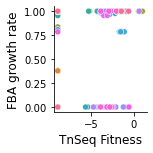

In [15]:
g = sns.relplot(x='fitness', y='fba', hue='gene', data=filtered[filtered.condition.eq(filtered.condition.unique()[20])], height=2, legend=False)
g.set_xlabels('TnSeq Fitness', fontsize=12)
g.set_ylabels('FBA growth rate', fontsize=12)
g.set_titles('{col_name}')
plt.show()

all


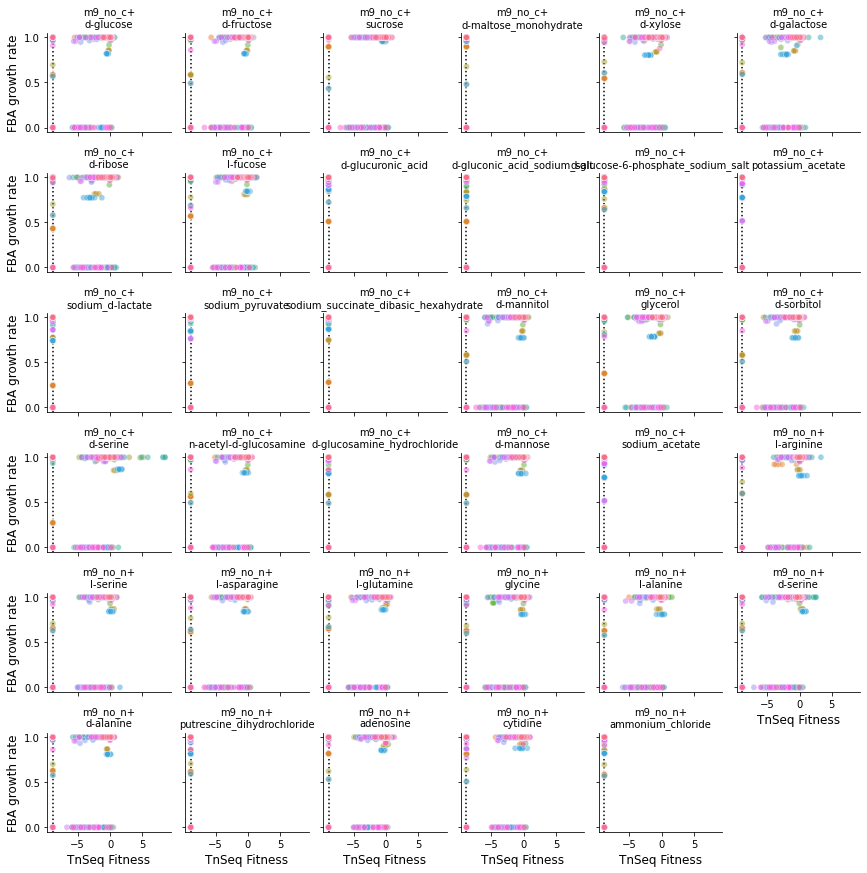

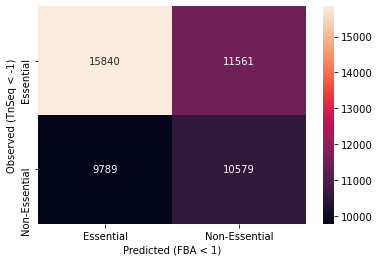

filtered


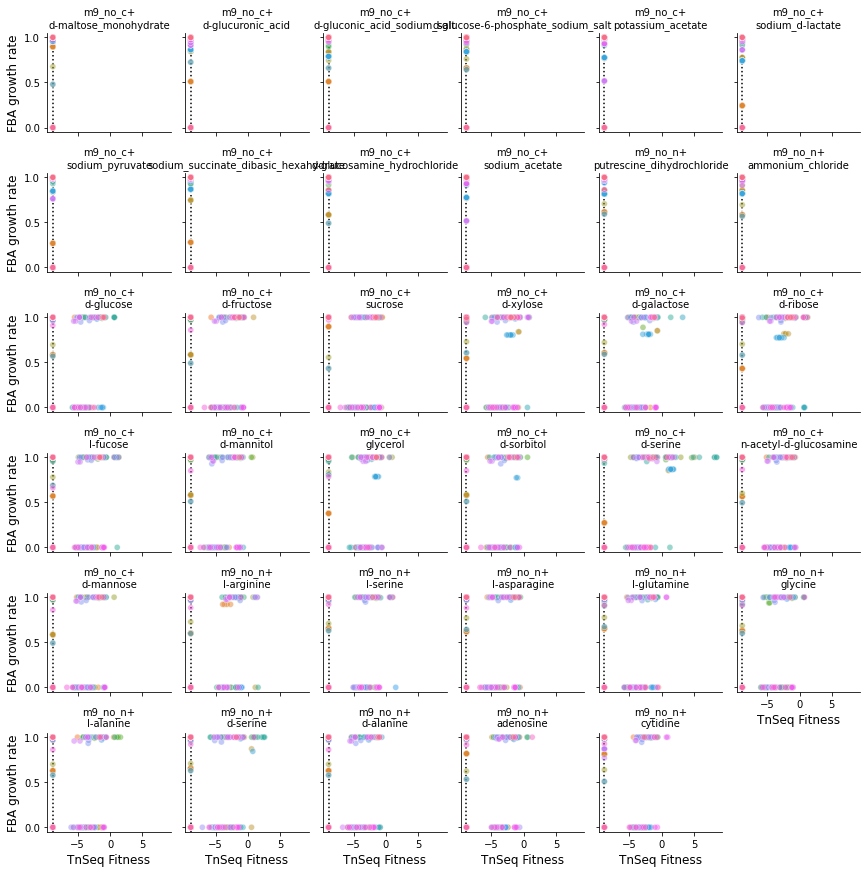

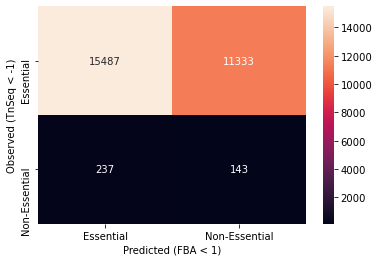

In [16]:
for data, name in zip([combo, filtered], ['all', 'filtered']):
    print(name)

    """Continuous comparison"""
    g = sns.relplot(x='fitness', y='fba', hue='gene', data=data, col='col_name', height=2, alpha=.5, col_wrap=6, legend=False)
    for ax in g.axes.ravel():
        ax.axvline(na_fill, zorder=0, color='k', ls=':')
    g.set_xlabels('TnSeq Fitness', fontsize=12)
    g.set_ylabels('FBA growth rate', fontsize=12)
    g.set_titles('{col_name}')
    plt.show()

    """Joinplot"""
#     g = sns.jointplot(x='fitness', y='fba', hue='condition', data=data)
#     plt.show()

    """Confusion matrix"""
    tnseq_thresh = -1
    fba_thresh = 1
    conf_matrix = pd.DataFrame(confusion_matrix(data.fitness.lt(tnseq_thresh), data.fba.lt(fba_thresh), [True, False]), ['Essential', 'Non-Essential'], ['Essential', 'Non-Essential'])
    sns.heatmap(conf_matrix, annot=True, fmt='d')
    plt.xlabel('Predicted (FBA < %d)' % fba_thresh)
    plt.ylabel('Observed (TnSeq < %d)' % tnseq_thresh)
    plt.show()

# Most conservative: just essential

In [112]:
"""Just essential in lb"""
essential = filtered[filtered.tnseq_essential]
essential.head()

,gene,condition,fba,fitness,tscore,tnseq_essential,col_name,anaerobic
3,aas,m9_no_c+d-maltose_monohydrate,1.000000,-8.8578,NaN,True,m9_no_c+\nd-maltose_monohydrate,False
8,aas,m9_no_c+d-glucuronic_acid,0.971354,-8.8578,NaN,True,m9_no_c+\nd-glucuronic_acid,False
9,aas,m9_no_c+d-gluconic_acid_sodium_salt,0.977411,-8.8578,NaN,True,m9_no_c+\nd-gluconic_acid_sodium_salt,False
10,aas,m9_no_c+d-glucose-6-phosphate_sodium_salt,0.967615,-8.8578,NaN,True,m9_no_c+\nd-glucose-6-phosphate_sodium_salt,False
11,aas,m9_no_c+potassium_acetate,0.988833,-8.8578,NaN,True,m9_no_c+\npotassium_acetate,False


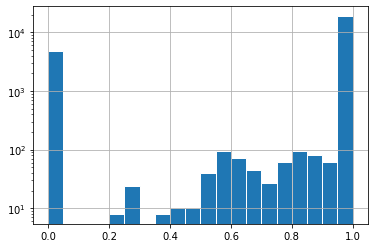

In [113]:
essential.fba.hist(bins=20, ec='w')
plt.yscale('log')
plt.show()

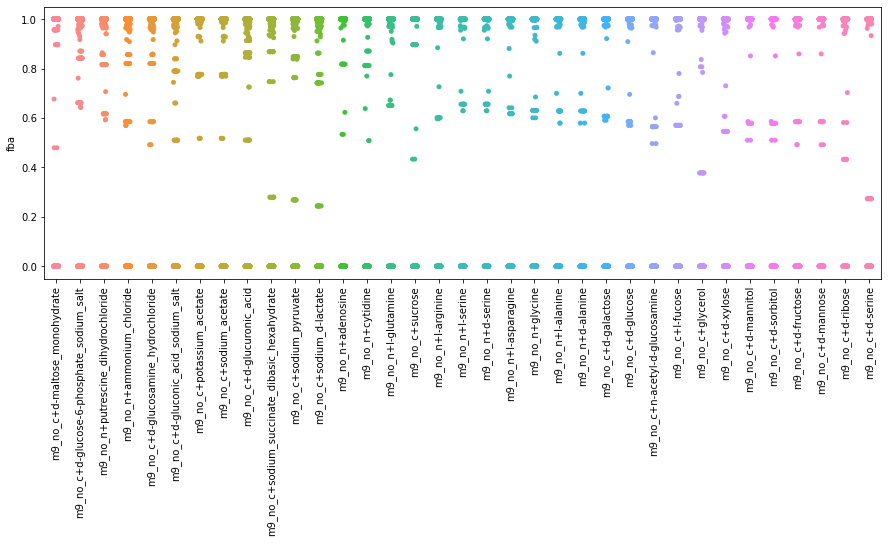

In [114]:
"""Distribution of FBA for most conservative case"""
plt.figure(figsize=(15, 5))
order = essential.groupby('condition').fba.mean().sort_values(ascending=False).index
sns.stripplot(x='condition', y='fba', data=essential, order=order)
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

Looks like the problem could be with genes, not conditions

In [115]:
"""Pivot essential fitnesses"""
essential_pivotted = essential.pivot('gene', 'condition', 'fba').fillna(0)
essential_pivotted.head()

condition,m9_no_c+d-fructose,m9_no_c+d-galactose,m9_no_c+d-gluconic_acid_sodium_salt,m9_no_c+d-glucosamine_hydrochloride,m9_no_c+d-glucose,m9_no_c+d-glucose-6-phosphate_sodium_salt,m9_no_c+d-glucuronic_acid,m9_no_c+d-maltose_monohydrate,m9_no_c+d-mannitol,m9_no_c+d-mannose,...,m9_no_n+cytidine,m9_no_n+d-alanine,m9_no_n+d-serine,m9_no_n+glycine,m9_no_n+l-alanine,m9_no_n+l-arginine,m9_no_n+l-asparagine,m9_no_n+l-glutamine,m9_no_n+l-serine,m9_no_n+putrescine_dihydrochloride
gene,,,,,,,,,,,,,,,,,,,,,
aas,0.000000e+00,0.000000e+00,9.774112e-01,9.675836e-01,0.000000e+00,9.676151e-01,9.713536e-01,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,9.731254e-01
accA,4.713524e-16,5.195874e-15,-5.240342e-15,-6.056836e-16,9.022757e-16,2.279756e-16,5.557275e-17,0.000000e+00,6.052015e-14,8.655478e-17,...,9.649013e-13,-9.984819e-15,-6.779116e-18,5.236961e-16,6.307136e-16,1.606896e-15,1.662872e-15,-1.755791e-16,2.867854e-16,-1.419960e-13
accB,-7.434407e-17,-3.703673e-17,1.623041e-13,-5.408609e-16,5.672073e-16,0.000000e+00,0.000000e+00,0.000000e+00,-1.329861e-15,3.436646e-15,...,-1.200136e-14,-8.090920e-16,-4.764792e-16,8.665201e-16,0.000000e+00,-3.667543e-16,6.280484e-15,-1.900082e-14,5.649075e-16,-4.440115e-13
accC,-9.506318e-17,-6.059146e-15,-1.303229e-16,0.000000e+00,7.464645e-15,-5.115272e-16,7.227130e-17,-8.393031e-15,0.000000e+00,-9.388161e-16,...,-4.930797e-14,6.530657e-15,-3.034526e-15,-1.776538e-13,-3.707371e-12,2.714523e-16,4.201756e-16,-3.848251e-15,-2.049293e-14,1.762792e-15
accD,1.258220e-15,0.000000e+00,-1.107913e-15,1.378501e-16,-3.049707e-17,1.909260e-16,5.383869e-16,5.629177e-15,4.019940e-16,2.716328e-16,...,1.181960e-16,-1.284239e-15,-1.102261e-16,1.551477e-16,3.862666e-16,-4.902385e-16,-4.273320e-16,-9.806556e-17,7.648089e-21,-1.588430e-15


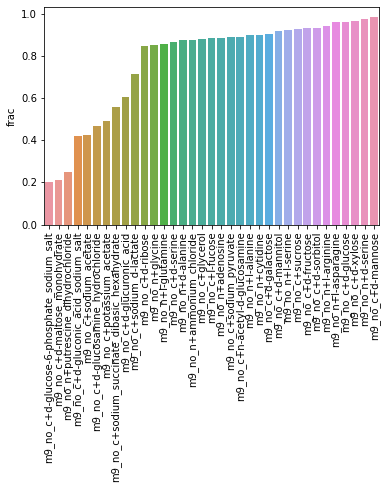

In [125]:
sns.barplot(x='condition', y='frac', data=essential_pivotted.lt(1).mean().reset_index(name='frac').sort_values('frac'))
plt.xticks(rotation=90)
plt.xlabel('')
plt.show()

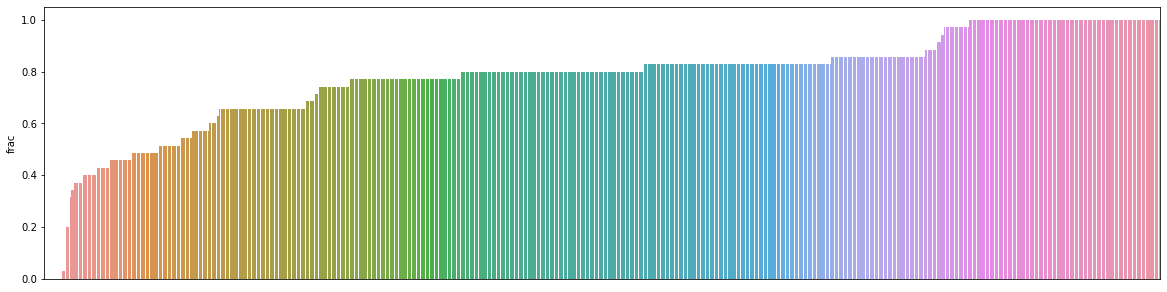

In [127]:
plt.figure(figsize=(20, 5))
sns.barplot(x='gene', y='frac', data=essential_pivotted.lt(1).mean(1).reset_index(name='frac').sort_values('frac'))
plt.xticks([])
plt.xlabel('')
plt.show()